In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('train.csv')

data.set_index('Id',inplace=True)

y = data.SalePrice
X_train = data.drop('SalePrice',axis=1)

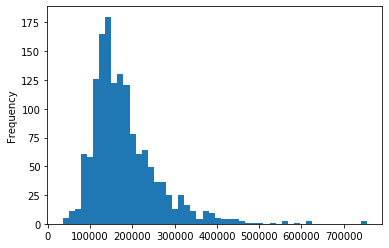

In [2]:
y.plot(kind='hist',bins=50)

In [3]:
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import power_transform

#Convert target to log-normal distribution
y = np.log(y)

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

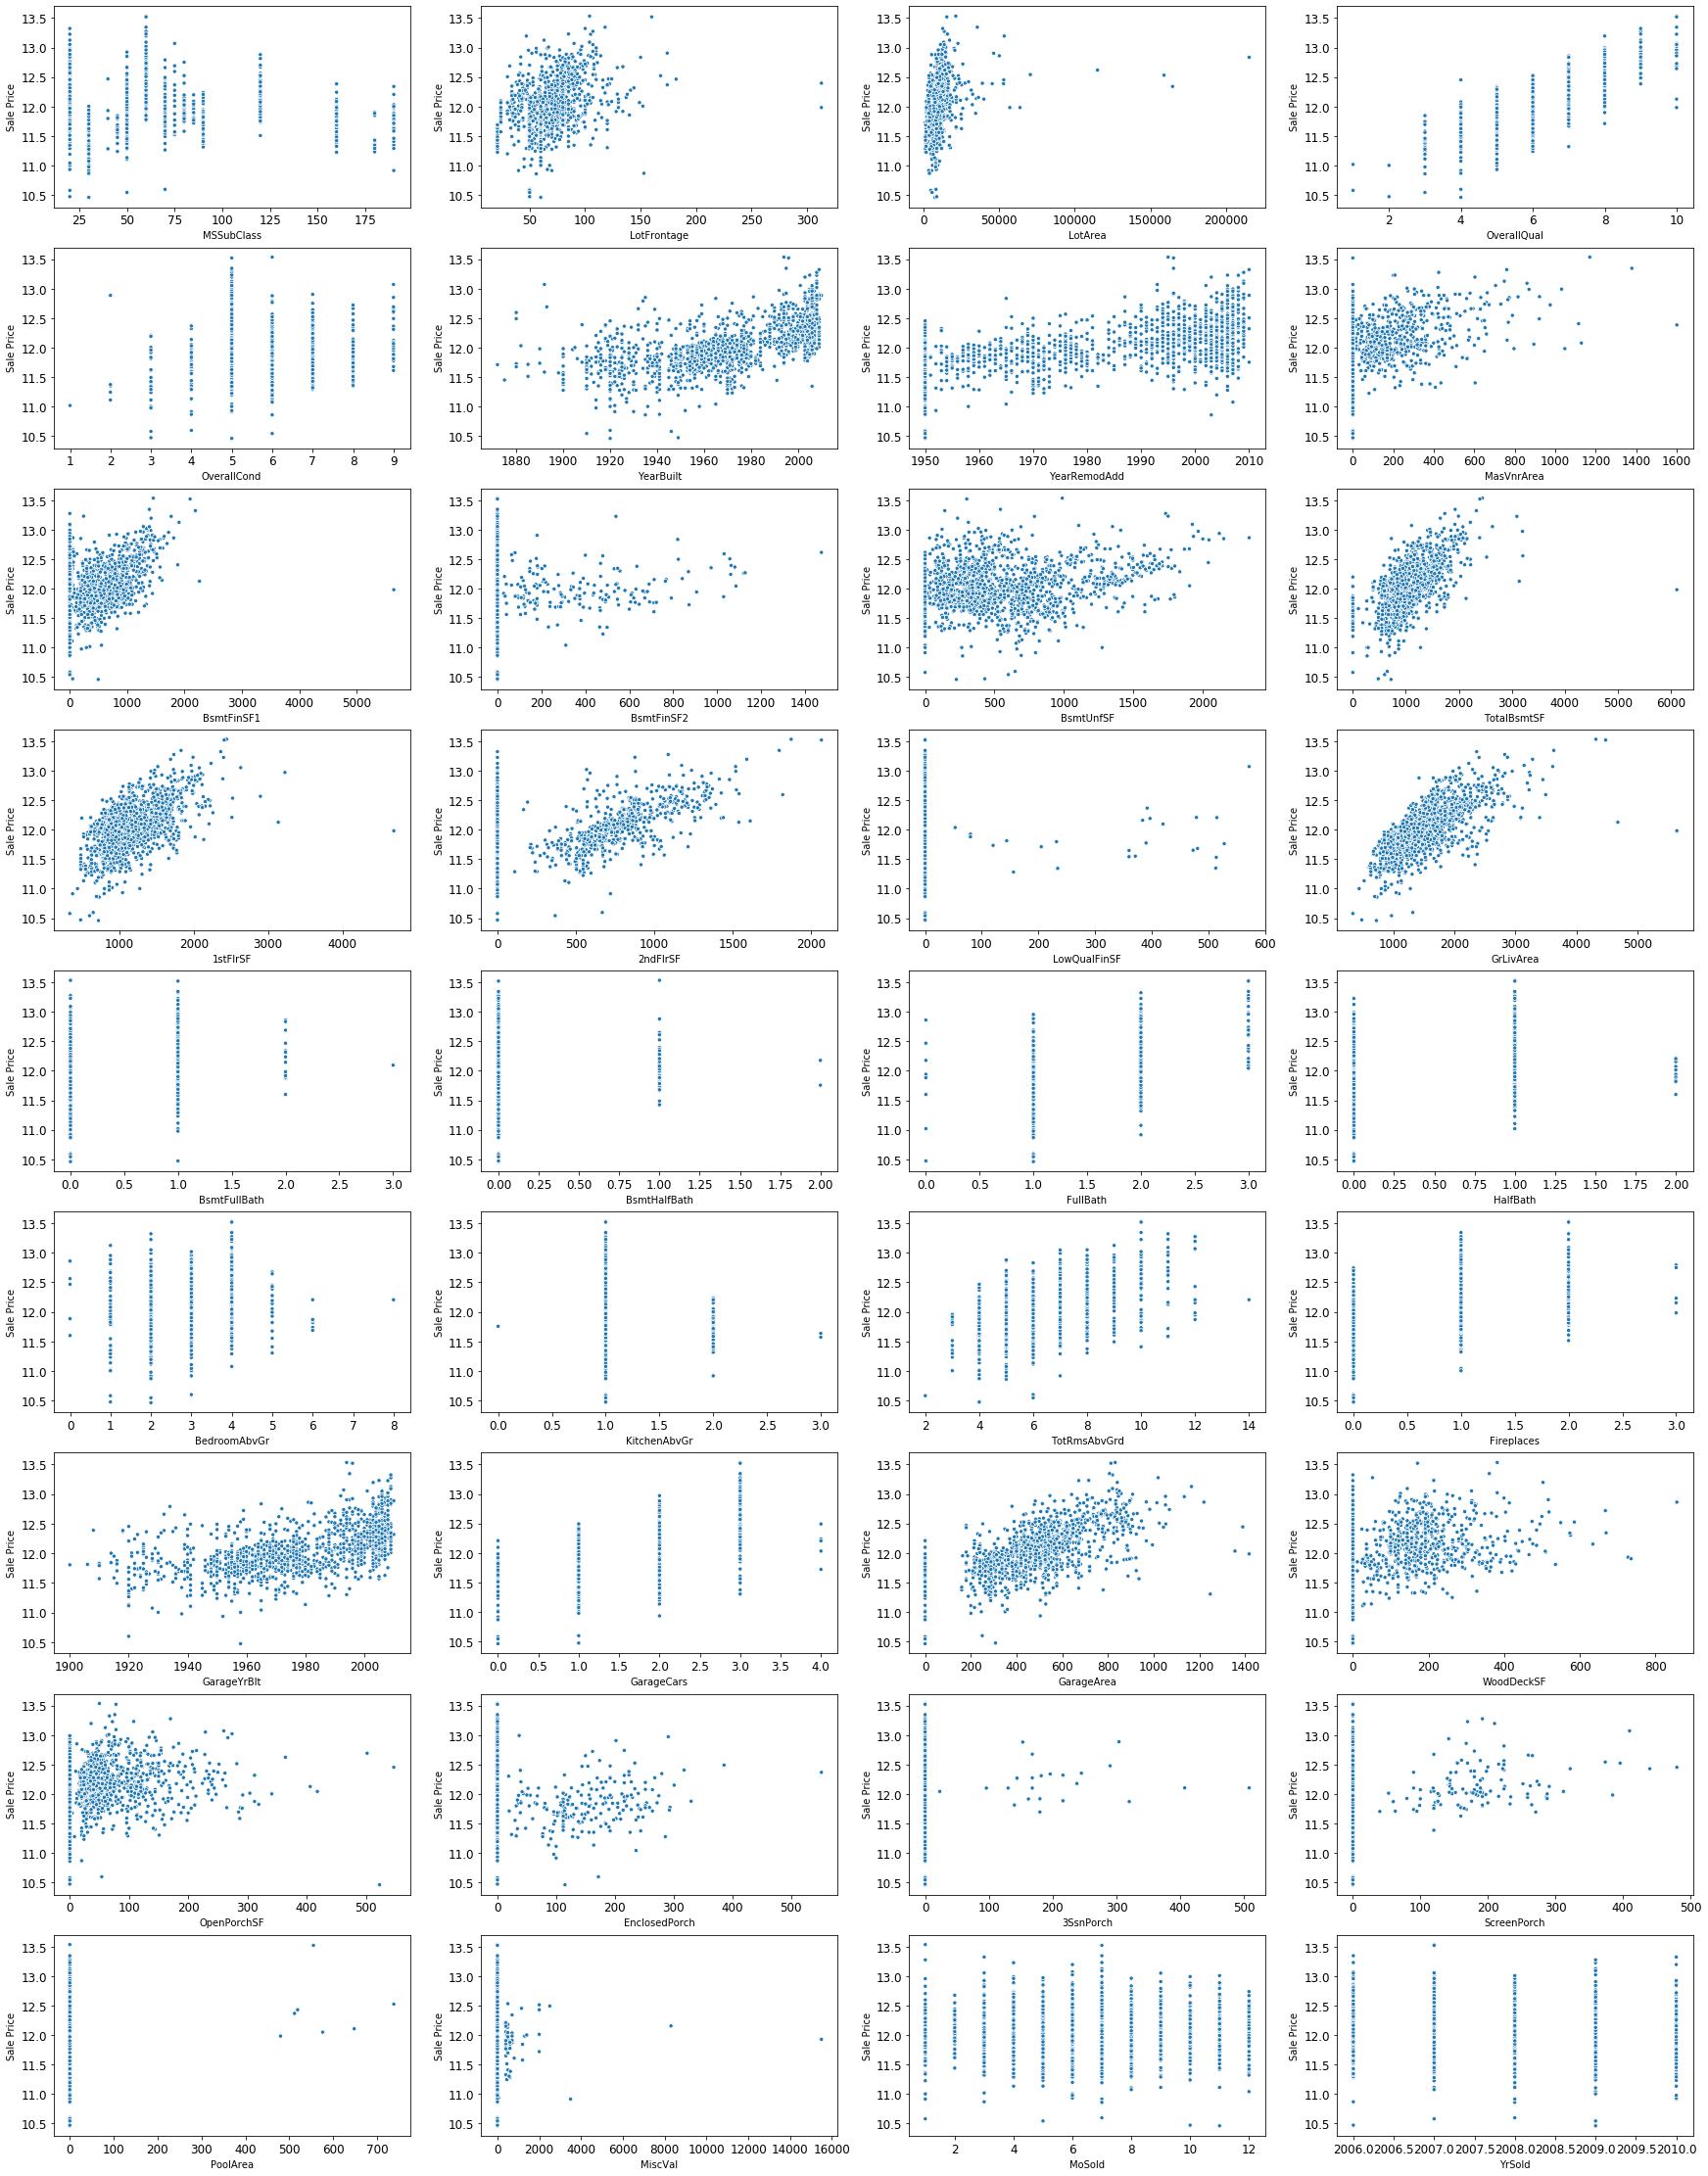

In [4]:
import seaborn as sns

num_cols = X_train.select_dtypes(include=np.number).columns

n_cols = 4
n_rows = np.ceil(len(num_cols)/n_cols)
    
plt.figure(figsize=(30,40))
for i,col in enumerate(num_cols):
    plt.subplot(n_rows,n_cols,i+1)
    sns.scatterplot(X_train[col],y,size=1,
                   legend = False)
    
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
plt.tight_layout

In [5]:
def log_trans(df):
    '''
    One large function to perform all dataframe prep
    '''
    
    #Log transform certain columns
    log_trans_cols = ['LotArea','1stFlrSF','GrLivArea']
    for col in log_trans_cols:
        df[col] = np.log(df[col])  

In [6]:
def imp_some_nans(df):
    '''
    Impute certain NaN values that have a specific meaning
    '''
    
    #Alley access
    df['Alley'] = df['Alley'].fillna('NoAlley')
    
    #Basement
    df['BsmtQual'] = df['BsmtQual'].fillna('NoBsmt')
    df['BsmtCond'] = df['BsmtCond'].fillna('NoBsmt')
    df['BsmtExposure'] = df['BsmtExposure'].fillna('NoBsmt')
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NoBsmt')
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NoBsmt')
    
    #Fireplace
    df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')
    
    #Garage
    df['GarageType'] = df['GarageType'].fillna('NoGarage')
    df['GarageFinish'] = df['GarageFinish'].fillna('NoGarage')
    df['GarageQual'] = df['GarageQual'].fillna('NoGarage')
    df['GarageCond'] = df['GarageCond'].fillna('NoGarage')
    
    #Pool
    df['PoolQC'] = df['PoolQC'].fillna('NoPool')
    
    #Fence
    df['Fence'] = df['Fence'].fillna('NoFence')
    
    #Misc Feature
    df['MiscFeature'] = df['MiscFeature'].fillna('NoMisc')
    

In [7]:
def new_feat(df):
    '''
    Generate new feature columns
    '''
    
    #Numerical cols with lots of zero
    df['HasMsVnr'] = (df['MasVnrArea'] != 0) * 1
    df['HasFinBsmt'] = ((df['BsmtFinSF1'] != 0) | (df['BsmtFinSF2'] != 0)) * 1
    df['HasUnFinBsmt'] = (df['BsmtUnfSF'] != 0) * 1
    df['Has2ndFlr'] = (df['2ndFlrSF'] != 0) * 1
    df['HasBsmtBath'] = ((df['BsmtFullBath'] != 0) | (df['BsmtHalfBath'] != 0)) * 1
    df['HasWoodDk'] = (df['WoodDeckSF'] != 0) * 1
    df['HasOpnPrch'] = (df['OpenPorchSF'] != 0) * 1
    df['Has3SnPrch'] = (df['3SsnPorch'] != 0) * 1
    df['HasScrPrch'] = (df['ScreenPorch'] != 0) * 1   

In [8]:
#Run transform functions
log_trans(X_train)
imp_some_nans(X_train)
new_feat(X_train)

In [9]:
from sklearn.preprocessing import LabelEncoder

#Convert neighborhood column
lab_enc = LabelEncoder()
X_train['Neighborhood'] = lab_enc.fit_transform(X_train['Neighborhood'])

In [10]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,HasMsVnr,HasFinBsmt,HasUnFinBsmt,Has2ndFlr,HasBsmtBath,HasWoodDk,HasOpnPrch,Has3SnPrch,HasScrPrch
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,9.041922,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,Normal,1,1,1,1,1,0,1,0,0
2,20,RL,80.0,9.169518,Pave,NoAlley,Reg,Lvl,AllPub,FR2,...,Normal,0,1,1,0,1,1,0,0,0
3,60,RL,68.0,9.328123,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,Normal,1,1,1,1,1,0,1,0,0
4,70,RL,60.0,9.164296,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,Abnorml,0,1,1,1,1,0,1,0,0
5,60,RL,84.0,9.565214,Pave,NoAlley,IR1,Lvl,AllPub,FR2,...,Normal,1,1,1,1,1,1,1,0,0


In [11]:
#Impute NaNs and transform data
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

cat_cols = [col for col in X_train.columns 
            if X_train[col].dtype == 'object' and
           X_train[col].nunique() <= 20]
num_cols = list(X_train.select_dtypes(include=np.number).columns)

#Categorical Imputation
cat_imputer = Pipeline(steps = [
    ('imp',SimpleImputer(strategy='most_frequent')),
    ('OHE',OneHotEncoder(handle_unknown='ignore'))
])

#Numerical Imputation
num_imputer = SimpleImputer(strategy='mean')

#Bundled numerical and categorical transformer
transformer = ColumnTransformer(transformers = [
    ('num',num_imputer,num_cols),
    ('cat',cat_imputer,cat_cols)
])

X_train_mod = pd.DataFrame(transformer.fit_transform(X_train))

In [12]:
X_train_mod

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,60.0,65.0,9.041922,5.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9.169518,24.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,9.328123,5.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9.164296,6.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,9.565214,15.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,8.976768,8.0,6.0,5.0,1999.0,2000.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20.0,85.0,9.486076,14.0,6.0,6.0,1978.0,1988.0,119.0,790.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,70.0,66.0,9.109636,6.0,7.0,9.0,1941.0,2006.0,0.0,275.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,20.0,68.0,9.181632,12.0,5.0,6.0,1950.0,1996.0,0.0,49.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
from sklearn.model_selection import cross_val_score, KFold

def score_model(model,X,y):
    '''
    Run CV on inputted model
    '''
    # CV model
    kfold = KFold(n_splits=5)
    results = np.sqrt(-1 * cross_val_score(model, X, y, 
                              cv=kfold, scoring='neg_mean_squared_error',
                                  verbose=False))
    #Mean Results
    return results.mean()

In [26]:
from lightgbm import LGBMRegressor

#Light GBM
lgb = LGBMRegressor(n_estimators=500,learning_rate=0.01)
lgb_result = score_model(lgb,X_train_mod,y)
print(f'LGBM: {lgb_result}')

LGBM: 0.1313053323670595


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

#GBR
gbr = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1)
gbr_result = score_model(gbr,X_train_mod,y)
print(f'\nGBR: {gbr_result}')


GBR: 0.12516372353962646


In [27]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from lightgbm import LGBMRegressor

#XGBoost
xgb = XGBRegressor(n_estimators=550,learning_rate=0.06)
xgb_result = score_model(xgb,X_train_mod,y)
print(f'XGB: {xgb_result}')

#Random Forest
rfr = RandomForestRegressor(n_estimators=100)
rfr_result = score_model(rfr,X_train_mod,y)
print(f'RFR: {rfr_result}')

#Lasso Regression
las = Lasso(alpha=0.01)
las_result = score_model(las,X_train_mod,y)
print(f'Lasso: {las_result}')

#Ridge Regression
rid = Ridge()
rid_result = score_model(rid,X_train_mod,y)
print(f'Ridge: {rid_result}')

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:48:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:49:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:49:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:49:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.12711958088278943
RFR: 0.14230693848896186
Lasso: 0.1604298324773965
Ridge: 0.14186461709596343


In [30]:
from mlxtend.regressor import StackingCVRegressor

#Stacking the various regressors initialized before
stack = StackingCVRegressor(regressors=(lgb,gbr,xgb ,rfr, las, rid),
                            meta_regressor= xgb, 
                            use_features_in_secondary=True)

#Fitting the data
stack_result = score_model(stack,np.array(X_train_mod),np.array(y))
print(f'Stack: {stack_result}')

[12:11:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:11:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [32]:
from sklearn.model_selection import train_test_split

X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_train_mod
                                                                            , y, test_size=0.3)

In [67]:
def combine_pred(X_test):
    '''
    Combine predictions from multiple models (must fit models before running)
    '''
    lgb_pred = lgb.predict(X_test) #4th
    gbr_pred = gbr.predict(X_test) #Best score
    xgb_pred = xgb.predict(X_test) #3rd
    rfr_pred = rfr.predict(X_test) #Less good
    las_pred = las.predict(X_test) #Less good
    rid_pred = rid.predict(X_test) #Less good
    stk_pred = stack.predict(np.array(X_test)) #2nd
    
    #Weight predictions
    final_predictions = (0.4 * gbr_pred) +\
    (0.2 * stk_pred) + (0.15 * xgb_pred) +\
    (0.1 * lgb_pred) + (0.05* rfr_pred) +\
    (0.05 * las_pred) + (0.05* rid_pred)
    
    return final_predictions

In [68]:
#Fit models
lgb.fit(X_train_comb,y_train_comb)
gbr.fit(X_train_comb,y_train_comb)
xgb.fit(X_train_comb,y_train_comb)
rfr.fit(X_train_comb,y_train_comb)
las.fit(X_train_comb,y_train_comb)
rid.fit(X_train_comb,y_train_comb)
stack.fit(np.array(X_train_comb),np.array(y_train_comb))

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:59:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:59:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.06,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=550,
                                                n_jobs=1, nthread=None,
                                                objective='reg:linear',
                                                random_state=0, reg_alpha=0,
                                          

In [69]:
#Combined predictions
comb_pred = combine_pred(X_test_comb)

In [70]:
from sklearn.metrics import mean_squared_error

print('\nCombined prediction: {}'.format(
    np.sqrt(mean_squared_error(y_test_comb,comb_pred))))


Combined prediction: 0.12639539316919085


In [73]:
#Fit final stack model
stack.fit(np.array(X_train_mod),np.array(y))

[15:17:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.06,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=550,
                                                n_jobs=1, nthread=None,
                                                objective='reg:linear',
                                                random_state=0, reg_alpha=0,
                                          

In [71]:
#Load test data
test = pd.read_csv('test.csv')

test.set_index('Id',inplace=True)

#Run transform functions
log_trans(test)
imp_some_nans(test)
new_feat(test)
    
#Convert neighborhood column
test['Neighborhood'] = lab_enc.transform(test['Neighborhood'])

In [72]:
test_mod = pd.DataFrame(transformer.transform(test))

In [75]:
predictions = stack.predict(np.array(test_mod))

In [78]:
#Convert predictions back
final_predictions = np.exp(predictions)

#Save final predictions for submission
submission12 = pd.DataFrame(final_predictions,index=test.index,columns=['SalePrice'])
submission12.to_csv(r'Stack_v2.csv',index=True)

In [79]:
submission12.head()

,SalePrice
Id,
1461,125462.273438
1462,154491.609375
1463,185886.703125
1464,193694.781250
1465,175293.312500
